<h1>Fine-tuning DistilBERT for QA purposes<h1>

Using the SQuAD dataset: https://huggingface.co/datasets/rajpurkar/squad

The fine-tuning is adapted from the following tutorial: https://huggingface.co/docs/transformers/tasks/question_answering (excluding evaluation)

EM and F1 scores:


*   50 lines of training data, 1000 of test data
    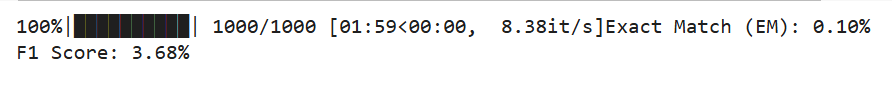
*   500 lines of training data, 1000 of test data
    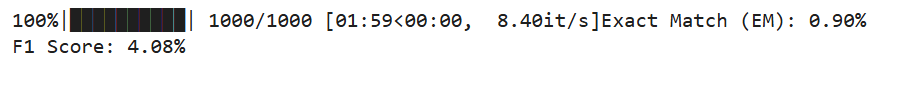
*   5000 lines of training data, 1000 of test data
    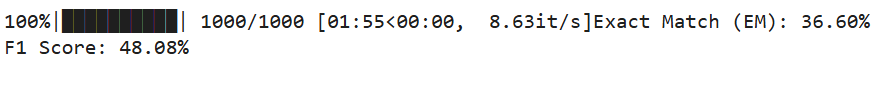
*   30000 lines of training data, 1000 of test data
    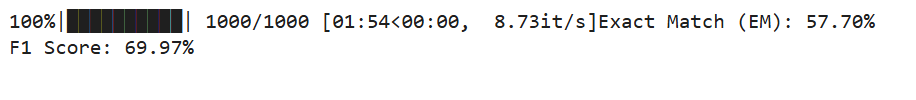


In [ ]:
!pip install transformers datasets evaluate

In [ ]:
from datasets import load_dataset

squad_loaded = load_dataset("squad", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Shuffle the data and choose a smaller subset due to limitations on computational power
squad_shuffled = squad_loaded.shuffle(seed=42)
#data_half = squad_shuffled.select(range(50))
#data_half = squad_shuffled.select(range(500))
#data_half = squad_shuffled.select(range(5000))
data_half = squad_shuffled.select(range(30000))
# split the data into training and testing data
squad = data_half.train_test_split(test_size=0.2)

In [ ]:
# Checking to see what the data looks like
#squad["train"][:5]

In [ ]:
from transformers import AutoTokenizer

# Loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [ ]:
# Preprocessing function for the data
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
# Tokenizing the data
tokenized_squad = squad.map(preprocess_function, batched=True, remove_columns=squad["train"].column_names)

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

In [ ]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 2
total_train_steps = (len(tokenized_squad["train"]) // batch_size) * num_epochs
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=total_train_steps,
)

In [ ]:
from transformers import TFAutoModelForQuestionAnswering

# Loading the DistilBERT model for fine-tuning
model = TFAutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForQuestionAnswering: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it

In [ ]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_squad["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)


In [ ]:
tf_validation_set = model.prepare_tf_dataset(
    tokenized_squad["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [ ]:
import tensorflow as tf

model.compile(optimizer=optimizer)

In [ ]:
# Training
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3)

Epoch 1/3
1500/1500 [==============================] - 1164s 763ms/step - loss: 1.9989 - val_loss: 1.3934
Epoch 2/3
1500/1500 [==============================] - 1123s 748ms/step - loss: 1.2121 - val_loss: 1.3283
Epoch 3/3
1500/1500 [==============================] - 1060s 707ms/step - loss: 1.0620 - val_loss: 1.3283


In [ ]:
# Testing

#question = "What genre of music does Cher make?"
#context = "Cher is a singer-songwriter who became famous in the 1970s along with her then-husband, Sonny. She has been known for her amazing style, acting skills, and her music. Her main genres are pop and EDM. Despite already being famous for over 50 years, her popularity is not fading."  #has 176 billion parameters and can generate text in 46 languages natural languages and 13 programming languages."

question = "Who got a touchdown making the score 10-7?"
context = "After a punt from both teams, Carolina got on track with a 9-play, 73-yard scoring drive. Newton completed 4 of 4 passes for 51 yards and rushed twice for 25 yards, while Jonathan Stewart finished the drive with a 1-yard touchdown run, cutting the score to 10–7 with 11:28 left in the second quarter. Later on, Broncos receiver Jordan Norwood received Brad Nortman's short 28-yard punt surrounded by Panthers players, but none of them attempted to make a tackle, apparently thinking Norwood had called a fair catch. Norwood had not done so, and with no resistance around him, he took off for a Super Bowl record 61-yard return before Mario Addison dragged him down on the Panthers 14-yard line. Despite Denver's excellent field position, they could not get the ball into the end zone, so McManus kicked a 33-yard field goal that increased their lead to 13–7."

In [ ]:
# Formatting inputs for testing
inputs = tokenizer(question, context, return_tensors="tf")

In [ ]:
# Obtaining answers from the fine-tuned model
outputs = model(**inputs)

In [ ]:
import tensorflow as tf
answer_start_index = int(tf.math.argmax(outputs.start_logits, axis=-1)[0])
answer_end_index = int(tf.math.argmax(outputs.end_logits, axis=-1)[0])

In [ ]:
# Printing the answer
predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer.decode(predict_answer_tokens)

'jonathan stewart'

In [ ]:
# Code for calculating evaluation metrics: EM and F1

import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from tqdm import tqdm
from collections import Counter
import string
import re
import random

# Load the SQuAD dataset (validation split for evaluation)
dataset = load_dataset("squad", split="validation")

# Select a random subset of 1000 instances
dataset = dataset.shuffle(seed=42).select(range(1000))

def normalize_text(text):
    """Normalize text by removing articles, punctuation, and extra whitespace."""
    def remove_articles(s):
        return re.sub(r'\b(a|an|the)\b', ' ', s)

    def white_space_fix(s):
        return ' '.join(s.split())

    def remove_punc(s):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in s if ch not in exclude)

    return white_space_fix(remove_articles(remove_punc(text.lower())))

def compute_exact_match(prediction, truth):
    """Compute exact match (EM) between prediction and ground truth."""
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    """Compute F1 score between prediction and ground truth."""
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    common = Counter(pred_tokens) & Counter(truth_tokens)
    num_same = sum(common.values())

    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    if num_same == 0:
        return 0

    precision = num_same / len(pred_tokens)
    recall = num_same / len(truth_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    return f1

def evaluate_model(dataset, model, tokenizer):
    """Evaluate the model on the dataset and compute EM and F1 scores."""

    exact_match = 0
    f1_score = 0

    for example in tqdm(dataset):
        question = example['question']
        context = example['context']
        answers = example['answers']['text']

        # Tokenize inputs
        inputs = tokenizer(question, context, return_tensors="tf", truncation=True)


        #outputs = model(**inputs)
        outputs = model(inputs, training=False)

        # Get the most likely start and end token positions
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

        start_index = int(tf.math.argmax(start_logits, axis=-1)[0])
        end_index = int(tf.math.argmax(end_logits, axis=-1)[0])

        # Decode the predicted answer
        input_ids = inputs['input_ids'][0]
        predicted_answer = tokenizer.decode(input_ids[start_index:end_index + 1], skip_special_tokens=True)

        # Compute scores for each ground truth answer and keep the best
        em = max(compute_exact_match(predicted_answer, truth) for truth in answers)
        f1 = max(compute_f1(predicted_answer, truth) for truth in answers)

        exact_match += em
        f1_score += f1

    # Calculate average scores
    total = len(dataset)
    exact_match = 100.0 * exact_match / total
    f1_score = 100.0 * f1_score / total

    return exact_match, f1_score

# Run evaluation
em_score, f1_score = evaluate_model(dataset, model, tokenizer)
print(f"Exact Match (EM): {em_score:.2f}%")
print(f"F1 Score: {f1_score:.2f}%")


100%|██████████| 1000/1000 [01:54<00:00,  8.73it/s]

Exact Match (EM): 57.70%
F1 Score: 69.97%


In [ ]:
## Save the model and tokenizer to Google Drive
#from google.colab import drive
#import os

#drive.mount('/content/drive')
#output_path = "my_output_path"
#output_dir = output_path

#if not os.path.exists(output_dir):
#    os.makedirs(output_dir)

#model.save_pretrained(output_dir)
#tokenizer.save_pretrained(output_dir)
#print(f"Model and tokenizer saved to {output_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model and tokenizer saved to /content/drive/My Drive/Colab Notebooks/Models/Best_30000/distilBERT_finetuned_QA_SQuAD


In [ ]:
#from google.colab import drive
#import os
#drive.mount('/content/drive')
#from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering

# Path to the saved model and tokenizer
#path_to_saved = "my_path_to_saved_model_and_tokenizer"
#model_dir = path_to_saved

# Load the model and tokenizer
#model = TFAutoModelForQuestionAnswering.from_pretrained(model_dir)
#tokenizer = AutoTokenizer.from_pretrained(model_dir)

#print("Model and tokenizer successfully loaded!")

Some layers from the model checkpoint at /content/drive/My Drive/Colab Notebooks/Models/Best_30000/distilBERT_finetuned_QA_SQuAD were not used when initializing TFDistilBertForQuestionAnswering: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at /content/drive/My Drive/Colab Notebooks/Models/Best_30000/distilBERT_finetuned_QA_SQuAD and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to b

Model and tokenizer successfully loaded!


In [ ]:
## Testing
#question = "Who got a touchdown making the score 10-7?"
#context = "After a punt from both teams, Carolina got on track with a 9-play, 73-yard scoring drive. Newton completed 4 of 4 passes for 51 yards and rushed twice for 25 yards, while Jonathan Stewart finished the drive with a 1-yard touchdown run, cutting the score to 10–7 with 11:28 left in the second quarter. Later on, Broncos receiver Jordan Norwood received Brad Nortman's short 28-yard punt surrounded by Panthers players, but none of them attempted to make a tackle, apparently thinking Norwood had called a fair catch. Norwood had not done so, and with no resistance around him, he took off for a Super Bowl record 61-yard return before Mario Addison dragged him down on the Panthers 14-yard line. Despite Denver's excellent field position, they could not get the ball into the end zone, so McManus kicked a 33-yard field goal that increased their lead to 13–7."

## Formatting inputs for testing
#inputs = tokenizer(question, context, return_tensors="tf")

## Obtaining answers from the fine-tuned model
#outputs = model(**inputs)

#import tensorflow as tf
#answer_start_index = int(tf.math.argmax(outputs.start_logits, axis=-1)[0])
#answer_end_index = int(tf.math.argmax(outputs.end_logits, axis=-1)[0])

## Printing the answer
#predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
#tokenizer.decode(predict_answer_tokens)